# Dataset size comparison

**Goal:** ...
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [2]:
summary = pd.DataFrame(columns=['test_accuracy', 'test_roc_auc', 'test_f1', 'test_average_precision'])
summary.index.name = 'dataset_size_and_algorithm'

## Get the data

In [12]:
# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)

In [13]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [14]:
# create the is_artefact class
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"
get_table(impact.is_artefact)

,count_,freq_
False,187012,96.3%
True,7199,3.7%


In [15]:
# choose label
label = 'is_artefact'

# choose features
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']
impact = impact[features + [label]].dropna()
    
# transform categorical features
categorical_features = ['VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
numerical_features = [f for f in features if not f in categorical_features]
impact = pd.get_dummies(impact, columns=categorical_features, sparse=True)

In [29]:
def get_X_and_y(number_of_negative_class_to_keep):
    # get selected dataset
    impact_selected = pd.concat([impact[impact.is_artefact],
                                 impact[~impact.is_artefact].iloc[:number_of_negative_class_to_keep]], ignore_index=True)

    # shuffle data
    rng = np.random.RandomState(42)
    permutation = rng.permutation(len(impact_selected))
    impact_selected = impact_selected.iloc[permutation]
    impact_selected.reset_index(drop=True, inplace=True)

    # get features matrix X (n_samples x n_features) and target array y (n_samples)
    X = impact_selected.drop(label, axis=1)
    X = X.astype(float)
    y = impact_selected[label]

    print(X.shape)
    print(y.shape)
    display(get_table(y))
    
    return (X, y)

In [30]:
positive_class_number = impact[impact.is_artefact].shape[0]
negative_class_number = impact[~impact.is_artefact].shape[0]

**Dataset 50% | 50%**

In [53]:
X_50_50, y_50_50 = get_X_and_y(positive_class_number)

(14398, 45)
(14398,)


,count_,freq_
True,7199,50.0%
False,7199,50.0%


**Dataset 20% | 80%**

In [54]:
X_20_80, y_20_80 = get_X_and_y(4 * positive_class_number)

(35995, 45)
(35995,)


,count_,freq_
False,28796,80.0%
True,7199,20.0%


**Dataset 4% | 96%**

In [55]:
X_04_96, y_04_96 = get_X_and_y(negative_class_number)

(194211, 45)
(194211,)


,count_,freq_
False,187012,96.3%
True,7199,3.7%


In [57]:
dataset_dict = {'50_50': (X_50_50, y_50_50),
                '20_80': (X_20_80, y_20_80),
                '04_96': (X_04_96, y_04_96)}

## Set cross-validation strategies

We choose stratified folds (made by preserving the percentage of samples for each class) for both outer and nested cross-validation.

In [34]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

## Random Forest

### Create job

In [60]:
job_list = []
for name in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_%s' % name, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs'))

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_50_50


<span style="color:green">Job < RandomForest_50_50 >: </span>✅ created

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_20_80


<span style="color:green">Job < RandomForest_20_80 >: </span>✅ created

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_04_96


<span style="color:green">Job < RandomForest_04_96 >: </span>✅ created

In [61]:
job_list = []
for name in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_%s' % name, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True))

<span style="color:green">Job < RandomForest_50_50 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_20_80 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_04_96 >: </span>✅ job found and reloaded

In [74]:
for job in job_list:
    X, y = dataset_dict[job.job_id[13:]]
    display(get_table(y))
    job.load_data(X, y)

,count_,freq_
True,7199,50.0%
False,7199,50.0%


➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_50_50


<span style="color:green">Job < RandomForest_50_50 >: </span>✅ data loaded

,count_,freq_
False,28796,80.0%
True,7199,20.0%


➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_20_80


<span style="color:green">Job < RandomForest_20_80 >: </span>✅ data loaded

,count_,freq_
False,187012,96.3%
True,7199,3.7%


➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_04_96


<span style="color:green">Job < RandomForest_04_96 >: </span>✅ data loaded

In [75]:
%%writefile {job_list[0].script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'n_estimators': [100, 500, 1000, 1500], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50, 100]}
]
model = GridSearchCV(RandomForestClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=20)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Writing ../ssh_remote_jobs/job_RandomForest_50_50/script.ipy


In [78]:
!cp {job_list[0].script_path} {job_list[1].script_path}
!cp {job_list[0].script_path} {job_list[2].script_path}

In [79]:
for job in job_list:
    job.run(n_jobs=20, short_job=False, memory=32)

➞ scp ../ssh_remote_jobs/job_RandomForest_50_50 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  930     5.1KB/s   00:00    
X.pkl                                         100% 3268KB  11.3MB/s   00:00    
y.pkl                                         100%   15KB 119.0KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_50_50
Job <28608408> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_50_50 -n 20 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_50_50 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_20_80 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  930     3.1KB/s   00:00    
X.pkl                                         100% 8162KB  17.3MB/s   00:00    
y.pkl                                         100%   36KB  61.0KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_20_80
Job <28608449> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_20_80 -n 20 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_20_80 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_04_96 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  930     2.3KB/s   00:00    
X.pkl                                         100%   43MB   7.2MB/s   00:06    
y.pkl                                         100%  190KB 190.0KB/s   00:01    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_04_96
Job <28608568> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_04_96 -n 20 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_04_96 >: </span>✅ submitted<br>

In [80]:
job_list = []
for name in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_%s' % name, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True))

for job in job_list:
    job.get_results()

<span style="color:green">Job < RandomForest_50_50 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_20_80 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_04_96 >: </span>✅ job found and reloaded

<span style="color:red">Job < RandomForest_50_50 >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

<span style="color:red">Job < RandomForest_20_80 >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

<span style="color:red">Job < RandomForest_04_96 >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

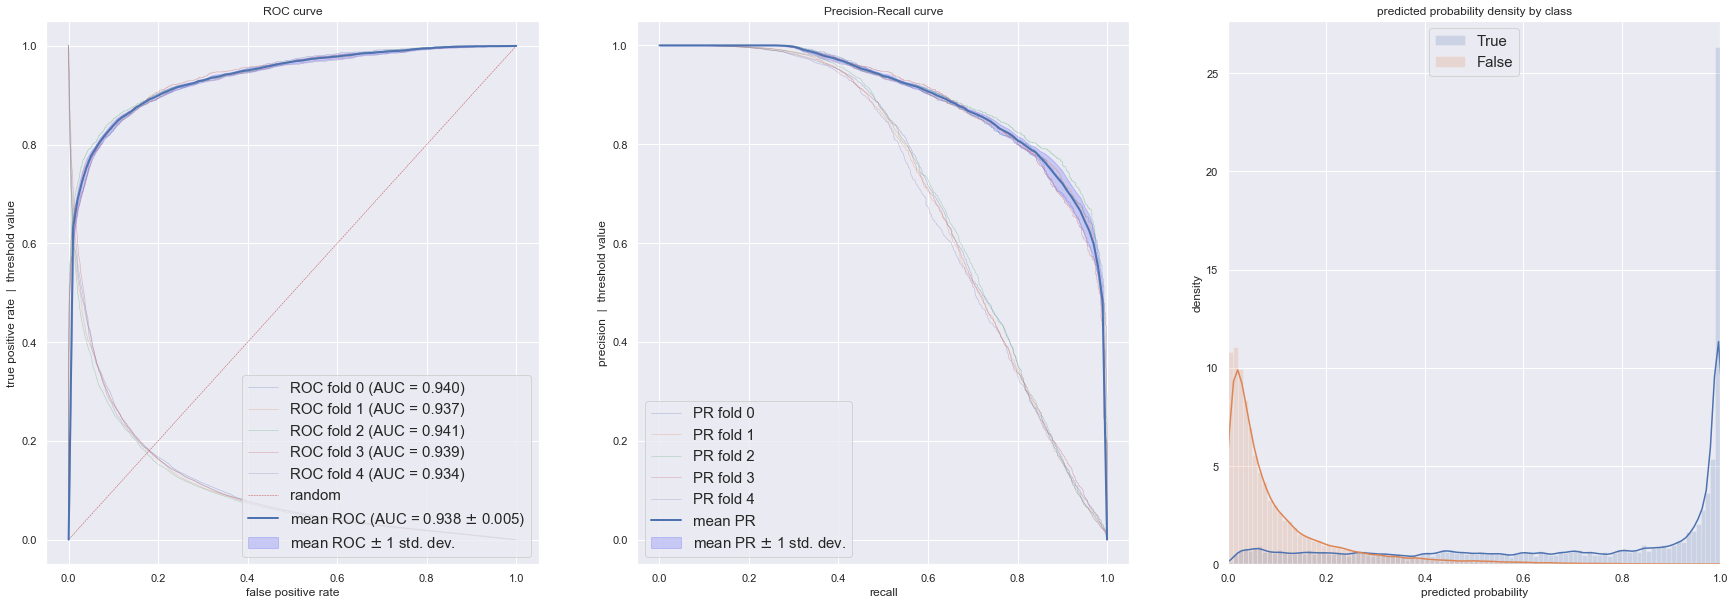

In [100]:
plot_threshold_decision_metrics(job.metrics)

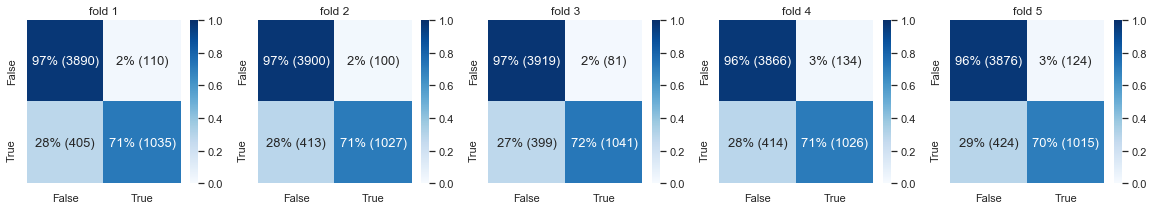

In [101]:
plot_confusion_matrix(job.metrics)

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50 100 200]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 1: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 2: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 3: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 4: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}


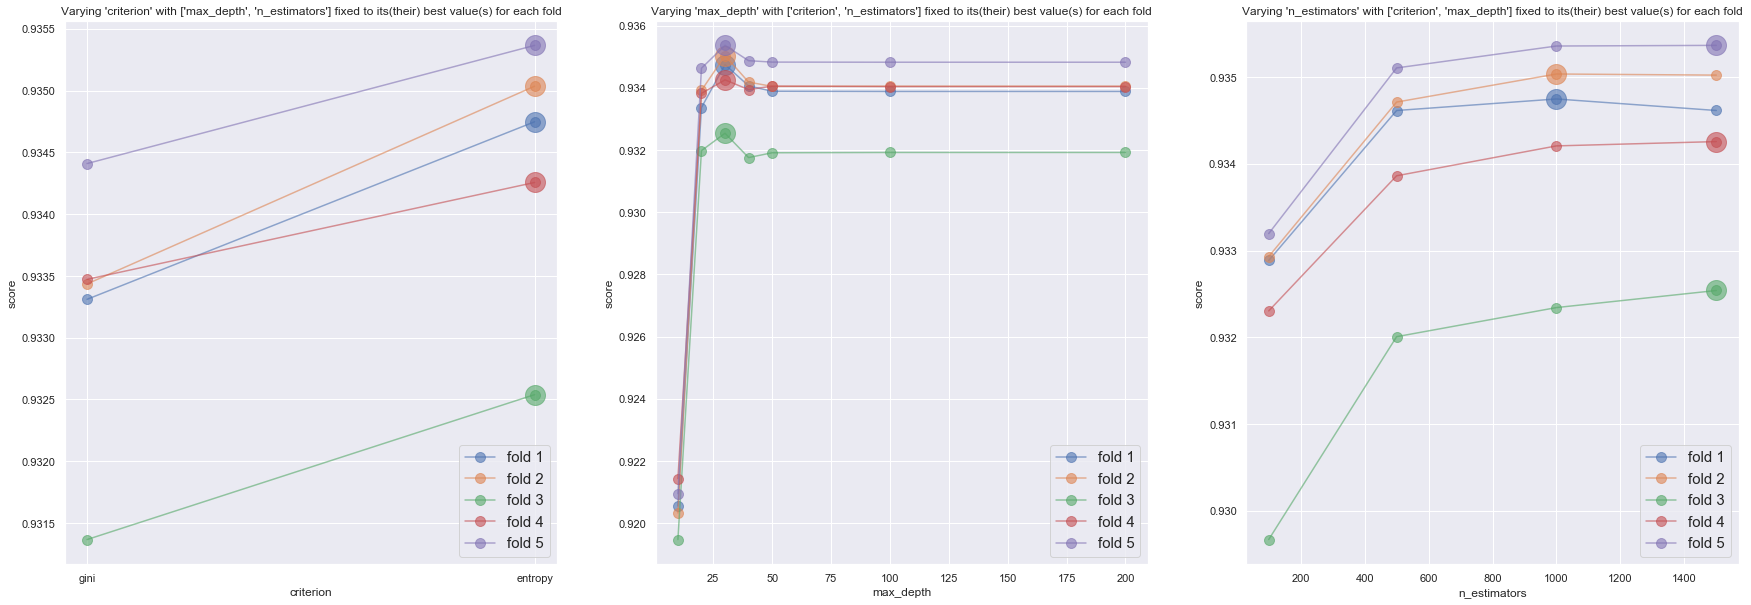

In [102]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [103]:
summary.loc['RandomForest_balanced'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

### Study feature importance of the best hyperparameted classifier

In [90]:
from sklearn.ensemble import RandomForestClassifier

model_bestRF = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=30, criterion='entropy', n_jobs=5)
model_bestRF.fit(X, y);

This is *gini importance* (and not the mean decrease accuracy), see https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined>

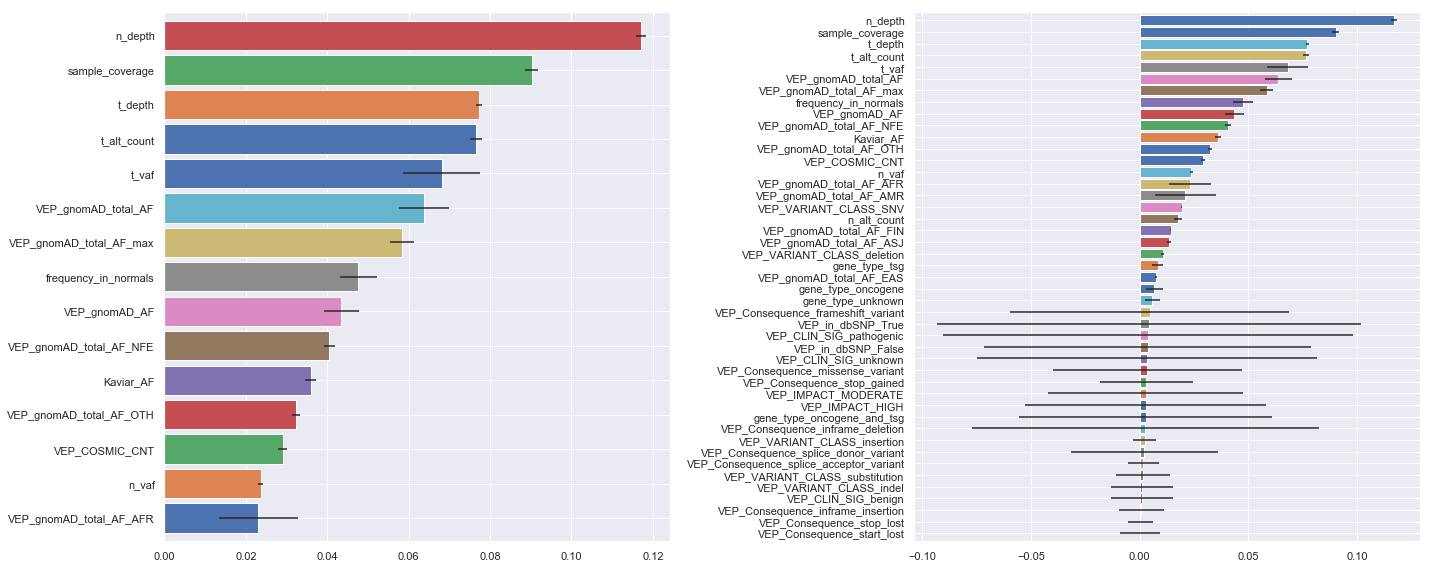

In [72]:
feature_importance = pd.DataFrame({'value': model_bestRF.feature_importances_.tolist()}, index=X.columns.tolist())
feature_importance.sort_values(by='value', axis=0, inplace=True)

feature_importance['inter_tree_variability'] = np.std([tree.feature_importances_ for tree in model_bestRF.estimators_], axis=0)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
feature_importance.tail(15).value.plot.barh(width=0.85, xerr=feature_importance.tail(15).inter_tree_variability)
plt.subplot(1, 2, 2)
feature_importance.value.plot.barh(width=0.85, xerr=feature_importance.inter_tree_variability)
plt.tight_layout()